# Scraping Clothes Industry: some web scraping functions to generate data frames from articles prices among the internet


This project implements some useful functions applying web scraping to a hypothetical case study, our goal is to scrape clothes prices among the internet to populate a data frame that could be saved and uploaded automatically as demanded. The project is conceived as useful in enterprises scenarios: for detecting competition prices, as input for decision taking and for marketing campaigns. 

The case study is delimited to the Uruguay market and to the “casual clothes” segment, but the same code could be extended to different items and countries. The code is written in Python language and tries to apply some of the most common web scraping libraries in a beginners friendly way but introducing also the utilities of function coding.


### 1. Libraries and html context

We are going to use the following libraries:

In [1]:
from IPython.display import Image

from urllib.request import urlopen
from bs4 import BeautifulSoup
from scrapy import Selector

import requests
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 


After importing the necessary modules, we need to know how to access the prices links on the web. As a strategy for this project we relied on a particular site called Mercado Libre, a company that offers a web trade platform used also by particulars as by big companies. Being the leader in e-commerce for Latinamerica and with 76, 1 million active users at november 2020, Mercado Libre is without doubts a reliable source for prices searches in the continent. Taking advantage of Mercado Libre as a trustable and standardized platform where different companies expose their products prices, we went there to extract our data.

There are different ways of scraping web data using Python: libraries such as “Requests”, “Beautiful Soup”, “Selenium” and “Scrapy” are all good options to handle html web services. For all of them , the first step 	will always consist in knowing and understanding the current web pages you are scraping on. For our case we would be taking information from different official stores sites in Mercado Libre.

Nowadays almost every web service could be inspected in its html format, and this is the form in which we are extracting the data as a first step. As it could be seen in the below image, we can enter in one official clothing site, right click at a particular price and go to “inspect”.

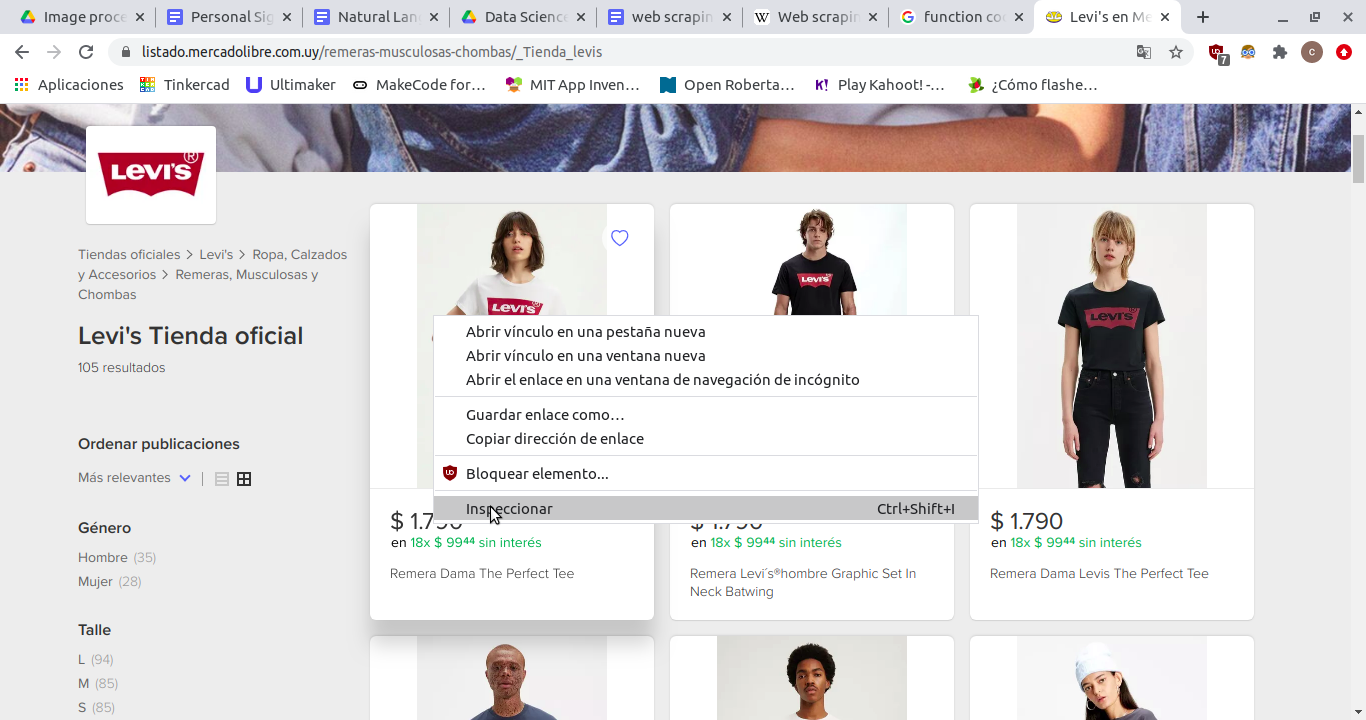

In [2]:
Image(filename='webscrapingimage1.png')

Image two shows how it is displayed the html element that refers to that specific price. Depending in which libraries are you working and in which kind of notation are you going to scrape data (CSS and XPath are the two most common ones) the following steps could change, but for this project we proceed to right click on the html price element, then go to copy and copy selector.

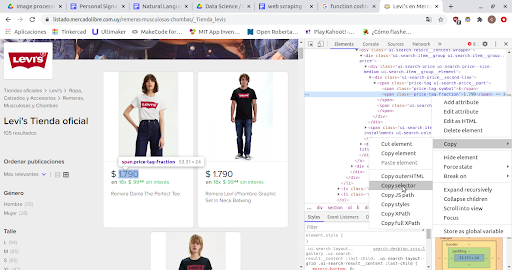

In [15]:
Image('webscrapingimage2.png')


If we then paste the selector element in our code editor we would have a long string with the desired data and alot of not useful information for our goal. Above there are showed examples of three prices of differents sites in Mercado Libre:

#root-app > div > div.ui-search-main.ui-search-main--official-store > section > ol:nth-child(1) > li:nth-child(1) > div > div > a > div > div.ui-search-item__group.ui-search-item__group--price > div > div > span.price-tag.ui-search-price__part > span.price-tag-fraction

#root-app > div > div.ui-search-main.ui-search-main--official-store > section > ol:nth-child(1) > li:nth-child(3) > div > div > a > div > div.ui-search-item__group.ui-search-item__group--price > div > div > span.price-tag.ui-search-price__part > span.price-tag-symbol

#root-app > div > div.ui-search-main.ui-search-main--official-store > section > ol:nth-child(2) > li:nth-child(2) > div > div > a > div > div.ui-search-item__group.ui-search-item__group--price > div > div > span.price-tag.ui-search-price__part > span.price-tag-symbol

We can see that despites the three paths are unique, they all share the same end,most precisely:

div > div > a > div > div.ui-search-item__group.ui-search-item__group--price > div > div > span.price-tag.ui-search-price__part > span.price-tag-symbol

That is because this is the part of the string that refers to the number of the price element, the other part refers to things like in which section it is stored, the number of the page, in which part of the screen it is shown, etc. And since Mercado Libre is consistent at storing elements, we can access any number of price elements of any product with that last Selector path, and that is exactly what we would do for our scraping.


### 3. Defining functions and a dataframe

Our goal is to scrape different websites to populate a dataframe for future consults, so we are going to handle an extense number of urls; and since replicating large amounts of almost the same code for each site is not a scalable practice, we are appealing to the properties of functions.

First we are going to simply define an object called “link” as a string with the selector path of the number, as we already seen the selector path is common to any price.

In [3]:
link = 'div > div > a > div > div.ui-search-item__group.ui-search-item__group--price > div > div > span.price-tag.ui-search-price__part > span.price-tag-fraction'


Then we define a function that takes as inputs an url and the link we just defined. As the firsts steps our function defines an “r” variable that gets the url and stores it as a “requests” object, then it uses the content of that object to generate a “soup” object for html. Our interest here is this soup object, that is nothing more than a piece of text with the same content of the raw html, but more friendly to the eye. We can then define  a “prices” variable that selects all the parts of the soup object that matches the link of interest (all the prices).

As a second step the function defines an empty list called “cash_list” and starts a for loop that for each price part in the prices variable execute the next commands: convert the price into a string, eliminate all the “.” if there are any so the numbers have all the same format, with regular expression grabs only the number part of the string, convert that string into an integer and finally append it to the empty list. As it passes through all strings it returns a list with all prices detected in the url in an integer format. 


In [4]:
def get_link(url, link):
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    prices = soup.select(link)

    cash_list = []
    
    for price in prices:
        price_str = str(price)   # Convert the price to a string
        price_str_notdot = price_str.replace(".","")   # Eliminate the "." so all numbers has the same format
        cash = re.search('\d+', price_str_notdot).group()   # Grab the number with regex
        cash = int(cash)             # Convert the string number to integer
        cash_list.append(cash)       # Append to the empty list
    
    return cash_list



So with our first function complete we are going to define a second function that is going to take the rest of the job. The function takes an object called “urls” (that must be a list of urls) and the link, then creates an empty list called “cash_sum” and starts a loop that for each url in urls applies our first function ( “get_list(url, link)” ) and sums the list of prices obtained to the empty list, returning at the end that list. This comes in handy to solve the problem of having multiple pages for each product of each clothes store.

In [5]:
def total_articles_sum(urls, link):
    
    cash_sum = []

    for url in urls:
        cash = get_link(url, link)
        cash_sum += cash
    
    return cash_sum


Then we define an empty Pandas data frame in a tidy format, this means that each observation corresponds to a unique row and each variable of interest to a unique column, for our case: “price”, “type” and “company”  . In the next part we would see how to populate the data frame using the functions we just defined.


In [6]:
df2 = pd.DataFrame(columns=['price', 'type', 'company'])
df2

,price,type,company


And for last, we define a third function that takes 3 inputs: the “price_company()” function, a company name and the generated data frame. Then it populates the data frame by rows for each clothes with the info of the price_company function applied to that company name, returning the modified data frame.

In [7]:
def populate_df(prices_company, company, df2):
        
        for price in prices_company['tshirts']:
                df2 = df2.append({'price': price, 'type':'tshirt', 'company':company}, ignore_index=True)
        
        for price in prices_company['pants']:
                df2 = df2.append({'price': price, 'type':'pant', 'company':company}, ignore_index=True)
        
        for price in prices_company['jackets']:
                df2 = df2.append({'price': price, 'type':'jacket', 'company':company}, ignore_index=True)
        
        for price in prices_company['boxers']:
                df2 = df2.append({'price': price, 'type':'boxer', 'company':company}, ignore_index=True)
        
        for price in prices_company['sweaters']:
                df2 = df2.append({'price': price, 'type':'sweater', 'company':company}, ignore_index=True)
        
        for price in prices_company['shirts']:
                df2 = df2.append({'price': price, 'type':'shirt', 'company':company}, ignore_index=True)
        
        for price in prices_company['shorts']:
                df2 = df2.append({'price': price, 'type':'short', 'company':company}, ignore_index=True)
        
        return df2


### 3. Extracting the data

Let’s apply everything we had developed and start scrapping real data. Our first choice would be Levis online shop in Mercado Libre. The clothes data we are extracting is referred to: t-shirts, pants, jackets, underwears, sweaters, shirts and shorts, in that order, and if we inspect we can see that for each type of clothes Levis has an independent page and sometimes even two or three pages for each type. As an approach to that issue we generate a dictionary of lists, in which each list corresponds to all the urls of each clothes type, so this dictionary of urls had all the information we needed in an organized and scalable format.

In [8]:
URLS_LEVIS = {
        'urls_levis_tshirts': 
                    ["https://listado.mercadolibre.com.uy/remeras-musculosas-chombas/_Tienda_levis#origin=os_carousel&position=1&id=572",
                     "https://listado.mercadolibre.com.uy/remeras-musculosas-chombas/_Desde_49_Tienda_levis",
                     "https://listado.mercadolibre.com.uy/remeras-musculosas-chombas/_Desde_97_Tienda_levis" ],
        
        'urls_levis_pants': 
                   ["https://listado.mercadolibre.com.uy/pantalones-jeans-joggings/_Tienda_levis",
                    "https://listado.mercadolibre.com.uy/pantalones-jeans-joggings/_Desde_49_Tienda_levis",
                    "https://listado.mercadolibre.com.uy/pantalones-jeans-joggings/_Desde_97_Tienda_levis"],
        
        'urls_levis_jackets': 
                   ["https://listado.mercadolibre.com.uy/camperas-tapados-gabardinas/_Tienda_levis"],

        'urls_levis_boxers': 
                   ["https://listado.mercadolibre.com.uy/ropa-interior-dormir/_Tienda_levis"],

        'urls_levis_sweaters': 
                   ["https://listado.mercadolibre.com.uy/ropa/buzos-canguros/_Tienda_levis"],

        'urls_levis_shirts': 
                   ["https://listado.mercadolibre.com.uy/ropa/camisas/_Tienda_levis"],

        'urls_levis_shorts': 
                   ["https://listado.mercadolibre.com.uy/ropa/bermudas-shorts/_Tienda_levis"]
        }


Now we just need to create a new dictionary and pass it the elements of our “total_articles_sum()” function. If we use each index of the URLS dictionary we would have as a result a new prices dictionary with all the information we want.

In [9]:
prices_levis = { 'tshirts': total_articles_sum(URLS_LEVIS['urls_levis_tshirts'], link), 
                 'pants': total_articles_sum(URLS_LEVIS['urls_levis_pants'], link),
                 'jackets': total_articles_sum(URLS_LEVIS['urls_levis_jackets'], link),
                 'boxers': total_articles_sum(URLS_LEVIS['urls_levis_boxers'], link), 
                 'sweaters': total_articles_sum(URLS_LEVIS['urls_levis_sweaters'], link),
                 'shirts': total_articles_sum(URLS_LEVIS['urls_levis_shirts'], link),
                 'shorts': total_articles_sum(URLS_LEVIS['urls_levis_shorts'], link)}

Let’s check the result for the first element, we can see it displays a list with all the t-shirts prices, that was exactly the information we were looking for.

In [13]:
print(prices_levis['tshirts'])

[1790, 1790, 1790, 1290, 1790, 1790, 1790, 1790, 2290, 1290, 1790, 1290, 1590, 1980, 1190, 1590, 1390, 1980, 1980, 1790, 1790, 2590, 1390, 1790, 1790, 2590, 1980, 1790, 1790, 1290, 1980, 1190, 1590, 1980, 2290, 1980, 1790, 1590, 1390, 1790, 1790, 1790, 1590, 3290, 1980, 1790, 1490, 1790, 1590, 1790, 1790, 1790, 1980, 1390, 2590, 1980, 1790, 1790, 2290, 1790, 1390, 1790, 2290, 1790, 1290, 1790, 1790, 1980, 1790, 1790, 1790, 2290, 2290, 1790, 1980, 1980, 1790, 1790, 1790, 2590, 1790, 1790, 1790, 1980, 1980, 1790, 1790, 1790, 1980, 1980, 1790, 1790, 1980, 1590, 3290, 1790]


The next step would be to populate the empty data frame with the Levis information, for that we just need to define a string variable with the company name and put in practice the “populate_df” function. If we print the actual data frame we would see the progress of our scrape.

In [10]:
levis = 'levis'
df2 = populate_df(prices_levis, levis, df2)
print(df2.head())

  price    type company
0  1790  tshirt   levis
1  1790  tshirt   levis
2  1790  tshirt   levis
3  1290  tshirt   levis
4  1790  tshirt   levis


Next steps are easy, we replicate the same code for each store, grabbing the urls and applying our functions, then we go populating the data frame until every store is loaded.

BAS

In [15]:
# Generate a dictionary of urls: each component of the dictinary is a list of all the pages (urls) of a clouthes
URLS_BAS = {
        'urls_bas_tshirts': 
                    ["https://listado.mercadolibre.com.uy/remeras-musculosas-chombas/_Tienda_bas",
                     "https://listado.mercadolibre.com.uy/remeras-musculosas-chombas/_Desde_49_Tienda_bas",
                     "https://listado.mercadolibre.com.uy/remeras-musculosas-chombas/_Desde_97_Tienda_bas"],       
        'urls_bas_pants': 
                   ["https://listado.mercadolibre.com.uy/pantalones-jeans-joggings/_Tienda_bas",
                    "https://listado.mercadolibre.com.uy/pantalones-jeans-joggings/_Desde_49_Tienda_bas"],        
        'urls_bas_jackets': 
                   ["https://listado.mercadolibre.com.uy/camperas-tapados-gabardinas/_Tienda_bas"],
        'urls_bas_boxers': 
                   ["https://listado.mercadolibre.com.uy/ropa-interior-dormir/_Tienda_bas"],
        'urls_bas_sweaters': 
                   ["https://listado.mercadolibre.com.uy/camperas-tapados-gabardinas/_Tienda_bas"],
        'urls_bas_shirts': 
                   ["https://listado.mercadolibre.com.uy/ropa/camisas/_Tienda_bas"],
        'urls_bas_shorts': 
                   ["https://listado.mercadolibre.com.uy/ropa/bermudas-shorts/_Tienda_bas"]
        }

# Generate a dictionary with each prices list

prices_bas = { 'tshirts': total_articles_sum(URLS_BAS['urls_bas_tshirts'], link), 
                 'pants': total_articles_sum(URLS_BAS['urls_bas_pants'], link),
                 'jackets': total_articles_sum(URLS_BAS['urls_bas_jackets'], link),
                 'boxers': total_articles_sum(URLS_BAS['urls_bas_boxers'], link), 
                 'sweaters': total_articles_sum(URLS_BAS['urls_bas_sweaters'], link),
                 'shirts': total_articles_sum(URLS_BAS['urls_bas_shirts'], link),
                 'shorts': total_articles_sum(URLS_BAS['urls_bas_shorts'], link)}

# Populate de DataFrame with the average price for each clouthes
bas = 'bas'
df2 = populate_df(prices_bas, bas, df2)


KEVINGSTON

In [16]:
# Generate a dictionary of urls: each component of the dictinary is a list of all the pages (urls) of a clouthes
URLS_KEVINGSTON = {
        'urls_kevingston_tshirts': 
                    ["https://listado.mercadolibre.com.uy/remeras-musculosas-chombas/_Tienda_kevingston",
                     "https://listado.mercadolibre.com.uy/remeras-musculosas-chombas/_Desde_49_Tienda_kevingston"],
        
        'urls_kevingston_pants': 
                   ["https://listado.mercadolibre.com.uy/pantalones-jeans-joggings/_Tienda_kevingston"],
        
        'urls_kevingston_jackets': 
                   ["https://listado.mercadolibre.com.uy/camperas-tapados-gabardinas/_Tienda_kevingston"],

        'urls_kevingston_boxers': 
                   ["https://listado.mercadolibre.com.uy/ropa-interior-dormir/_Tienda_kevingston",
                    "https://listado.mercadolibre.com.uy/ropa-interior-dormir/_Desde_49_Tienda_kevingston"],

        'urls_kevingston_sweaters': 
                   ["https://listado.mercadolibre.com.uy/ropa/buzos-canguros/_Tienda_kevingston"],

        'urls_kevingston_shirts': 
                   ["https://listado.mercadolibre.com.uy/ropa/camisas/_Tienda_kevingston"],

        'urls_kevingston_shorts': 
                   ["https://listado.mercadolibre.com.uy/ropa/bermudas-shorts/_Tienda_kevingston"]
        }

# Generate a dictionary with each prices list
prices_kevingston = { 'tshirts': total_articles_sum(URLS_KEVINGSTON['urls_kevingston_tshirts'], link), 
                      'pants': total_articles_sum(URLS_KEVINGSTON['urls_kevingston_pants'], link),
                      'jackets': total_articles_sum(URLS_KEVINGSTON['urls_kevingston_jackets'], link),
                      'boxers': total_articles_sum(URLS_KEVINGSTON['urls_kevingston_boxers'], link), 
                      'sweaters': total_articles_sum(URLS_KEVINGSTON['urls_kevingston_sweaters'], link),
                      'shirts': total_articles_sum(URLS_KEVINGSTON['urls_kevingston_shirts'], link),
                      'shorts': total_articles_sum(URLS_KEVINGSTON['urls_kevingston_shorts'], link)}

# Populate de DataFrame with the average price for each clouthes
kevingston = 'kevingston'
df2 = populate_df(prices_kevingston, kevingston, df2)


LA ISLA

In [17]:
# Generate a dictionary of urls: each component of the dictinary is a list of all the pages (urls) of a clouthes
URLS_LAISLA = {
        'urls_laisla_tshirts': 
                    ["https://listado.mercadolibre.com.uy/remeras-musculosas-chombas/_Tienda_la-isla",
                     "https://listado.mercadolibre.com.uy/remeras-musculosas-chombas/_Desde_49_Tienda_la-isla"],
        
        'urls_laisla_pants': 
                   ["https://listado.mercadolibre.com.uy/pantalones-jeans-joggings/_Tienda_la-isla"],
        
        'urls_laisla_jackets': 
                   ["https://listado.mercadolibre.com.uy/camperas-tapados-gabardinas/_Tienda_la-isla"],

        'urls_laisla_boxers': 
                   [],

        'urls_laisla_sweaters': 
                   ["https://listado.mercadolibre.com.uy/ropa/buzos-canguros/_Tienda_la-isla"],

        'urls_laisla_shirts': 
                   ["https://listado.mercadolibre.com.uy/ropa/camisas/_Tienda_la-isla"],

        'urls_laisla_shorts': 
                   ["https://listado.mercadolibre.com.uy/ropa/bermudas-shorts/_Tienda_la-isla",
                    "https://listado.mercadolibre.com.uy/ropa/bermudas-shorts/_Desde_49_Tienda_la-isla",
                    "https://listado.mercadolibre.com.uy/ropa/bermudas-shorts/_Desde_97_Tienda_la-isla"]
        }

# Generate a dictionary with each prices list

prices_laisla = { 'tshirts': total_articles_sum(URLS_LAISLA['urls_laisla_tshirts'], link), 
                 'pants': total_articles_sum(URLS_LAISLA['urls_laisla_pants'], link),
                 'jackets': total_articles_sum(URLS_LAISLA['urls_laisla_jackets'], link),
                 'boxers': total_articles_sum(URLS_LAISLA['urls_laisla_boxers'], link), 
                 'sweaters': total_articles_sum(URLS_LAISLA['urls_laisla_sweaters'], link),
                 'shirts': total_articles_sum(URLS_LAISLA['urls_laisla_shirts'], link),
                 'shorts': total_articles_sum(URLS_LAISLA['urls_laisla_shorts'], link)}

# Populate de DataFrame with the average price for each clouthes
laisla = 'laisla'
df2 = populate_df(prices_laisla, laisla, df2)


NORTHSALES

In [18]:
# Generate a dictionary of urls: each component of the dictinary is a list of all the pages (urls) of a clouthes
URLS_NORTHSALES = {
        'urls_northsales_tshirts': 
                    ["https://listado.mercadolibre.com.uy/remeras-musculosas-chombas/_Tienda_northsales-performance",
                     "https://listado.mercadolibre.com.uy/remeras-musculosas-chombas/_Desde_49_Tienda_northsales-performance"],
        
        'urls_northsales_pants': 
                   ["https://listado.mercadolibre.com.uy/pantalones-jeans-joggings/_Tienda_northsales-performance"],
        
        'urls_northsales_jackets': 
                   ["https://listado.mercadolibre.com.uy/camperas-tapados-gabardinas/_Tienda_north-sails"],

        'urls_northsales_boxers': 
                   [],

        'urls_northsales_sweaters': 
                   ["https://listado.mercadolibre.com.uy/ropa/buzos-canguros/_Tienda_north-sails"],

        'urls_northsales_shirts': 
                   ["https://listado.mercadolibre.com.uy/ropa/camisas/_Tienda_north-sails"],

        'urls_northsales_shorts': 
                   ["https://listado.mercadolibre.com.uy/ropa/bermudas-shorts/_Tienda_north-sails"]
        }

# Generate a dictionary with each prices list

prices_northsales = { 'tshirts': total_articles_sum(URLS_NORTHSALES['urls_northsales_tshirts'], link), 
                 'pants': total_articles_sum(URLS_NORTHSALES['urls_northsales_pants'], link),
                 'jackets': total_articles_sum(URLS_NORTHSALES['urls_northsales_jackets'], link),
                 'boxers': total_articles_sum(URLS_NORTHSALES['urls_northsales_boxers'], link), 
                 'sweaters': total_articles_sum(URLS_NORTHSALES['urls_northsales_sweaters'], link),
                 'shirts': total_articles_sum(URLS_NORTHSALES['urls_northsales_shirts'], link),
                 'shorts': total_articles_sum(URLS_NORTHSALES['urls_northsales_shorts'], link)}

# Populate de DataFrame with the average price for each clouthes
northsales = 'northsales'
df2 = populate_df(prices_northsales, northsales, df2)


CAT

In [19]:
# Generate a dictionary of urls: each component of the dictinary is a list of all the pages (urls) of a clouthes
URLS_CAT = {
        'urls_cat_tshirts': 
                    ["https://listado.mercadolibre.com.uy/remeras-musculosas-chombas/_Tienda_cat-lifestyle"],
        
        'urls_cat_pants': 
                   ["https://listado.mercadolibre.com.uy/pantalones-jeans-joggings/_Tienda_cat-lifestyle"],
        
        'urls_cat_jackets': 
                   ["https://listado.mercadolibre.com.uy/camperas-tapados-gabardinas/_Tienda_cat-lifestyle_NoIndex_True"],

        'urls_cat_boxers': 
                   [],

        'urls_cat_sweaters': 
                   [],

        'urls_cat_shirts': 
                   ["https://listado.mercadolibre.com.uy/ropa/camisas/_Tienda_cat-lifestyle"],

        'urls_cat_shorts': 
                   []
        }

# Generate a dictionary with each prices list

prices_cat = { 'tshirts': total_articles_sum(URLS_CAT['urls_cat_tshirts'], link), 
                 'pants': total_articles_sum(URLS_CAT['urls_cat_pants'], link),
                 'jackets': total_articles_sum(URLS_CAT['urls_cat_jackets'], link),
                 'boxers': total_articles_sum(URLS_CAT['urls_cat_boxers'], link), 
                 'sweaters': total_articles_sum(URLS_CAT['urls_cat_sweaters'], link),
                 'shirts': total_articles_sum(URLS_CAT['urls_cat_shirts'], link),
                 'shorts': total_articles_sum(URLS_CAT['urls_cat_shorts'], link)}

# Populate de DataFrame with the average price for each clouthes
cat = 'cat'
df2 = populate_df(prices_cat, cat, df2)


COLUMBIA

In [20]:
# Generate a dictionary of urls: each component of the dictinary is a list of all the pages (urls) of a clouthes
URLS_COLUMBIA = {
        'urls_columbia_tshirts': 
                    ["https://listado.mercadolibre.com.uy/remeras-musculosas-chombas/_Tienda_columbia-sportwear"],
        
        'urls_columbia_pants': 
                   ["https://listado.mercadolibre.com.uy/pantalones-jeans-joggings/_Tienda_columbia-sportwear"],
        
        'urls_columbia_jackets': 
                   ["https://listado.mercadolibre.com.uy/camperas-tapados-gabardinas/_Tienda_columbia-sportwear"],

        'urls_columbia_boxers': 
                   [],

        'urls_columbia_sweaters': 
                   ["https://listado.mercadolibre.com.uy/ropa/buzos-canguros/_Tienda_columbia-sportwear"],

        'urls_columbia_shirts': 
                   ["https://listado.mercadolibre.com.uy/ropa/camisas/_Tienda_columbia-sportwear"],

        'urls_columbia_shorts': 
                   ["https://listado.mercadolibre.com.uy/ropa/bermudas-shorts/_Tienda_columbia-sportwear"]
        }

# Generate a dictionary with each prices list

prices_columbia = { 'tshirts': total_articles_sum(URLS_COLUMBIA['urls_columbia_tshirts'], link), 
                 'pants': total_articles_sum(URLS_COLUMBIA['urls_columbia_pants'], link),
                 'jackets': total_articles_sum(URLS_COLUMBIA['urls_columbia_jackets'], link),
                 'boxers': total_articles_sum(URLS_COLUMBIA['urls_columbia_boxers'], link), 
                 'sweaters': total_articles_sum(URLS_COLUMBIA['urls_columbia_sweaters'], link),
                 'shirts': total_articles_sum(URLS_COLUMBIA['urls_columbia_shirts'], link),
                 'shorts': total_articles_sum(URLS_COLUMBIA['urls_columbia_shorts'], link)}

# Populate de DataFrame with the average price for each clouthes
columbia = 'columbia'
df2 = populate_df(prices_columbia, columbia, df2)


JACK & JONES

In [21]:
# Generate a dictionary of urls: each component of the dictinary is a list of all the pages (urls) of a clouthes
URLS_JACKJONES = {
        'urls_jackjones_tshirts': 
                    ["https://listado.mercadolibre.com.uy/remeras-musculosas-chombas/_Tienda_jack-jones"],
        
        'urls_jackjones_pants': 
                   ["https://listado.mercadolibre.com.uy/pantalones-jeans-joggings/_Tienda_jack-jonesr",
                   "https://listado.mercadolibre.com.uy/pantalones-jeans-joggings/_Desde_49_Tienda_jack-jones"],
        
        'urls_jackjones_jackets': 
                   ["https://listado.mercadolibre.com.uy/camperas-tapados-gabardinas/_Tienda_jack-jones"],

        'urls_jackjones_boxers': 
                   ["https://listado.mercadolibre.com.uy/ropa-interior-dormir/_Tienda_jack-jones"],

        'urls_jackjones_sweaters': 
                   ["https://listado.mercadolibre.com.uy/ropa/buzos-canguros/_Tienda_jack-jones"],

        'urls_jackjones_shirts': 
                   ["https://listado.mercadolibre.com.uy/ropa/camisas/_Tienda_jack-jones"],

        'urls_jackjones_shorts': 
                   []
        }

# Generate a dictionary with each prices list

prices_jackjones = { 'tshirts': total_articles_sum(URLS_JACKJONES['urls_jackjones_tshirts'], link), 
                 'pants': total_articles_sum(URLS_JACKJONES['urls_jackjones_pants'], link),
                 'jackets': total_articles_sum(URLS_JACKJONES['urls_jackjones_jackets'], link),
                 'boxers': total_articles_sum(URLS_JACKJONES['urls_jackjones_boxers'], link), 
                 'sweaters': total_articles_sum(URLS_JACKJONES['urls_jackjones_sweaters'], link),
                 'shirts': total_articles_sum(URLS_JACKJONES['urls_jackjones_shirts'], link),
                 'shorts': total_articles_sum(URLS_JACKJONES['urls_jackjones_shorts'], link)}

# Populate de DataFrame with the average price for each clouthes
jackjones = 'jackjones'
df2 = populate_df(prices_jackjones, jackjones, df2)


JEAN VERNIER

In [22]:
# Generate a dictionary of urls: each component of the dictinary is a list of all the pages (urls) of a clouthes
URLS_JEANVERNIER = {
        'urls_jeanvernier_tshirts': 
                    ["https://listado.mercadolibre.com.uy/remeras-musculosas-chombas/_Tienda_jean-vernier"],
        
        'urls_jeanvernier_pants': 
                   ["https://listado.mercadolibre.com.uy/pantalones-jeans-joggings/_Tienda_jean-vernier"],
        
        'urls_jeanvernier_jackets': 
                   ["https://listado.mercadolibre.com.uy/camperas-tapados-gabardinas/_Tienda_jean-vernier"],

        'urls_jeanvernier_boxers': 
                   [],

        'urls_jeanvernier_sweaters': 
                   ["https://listado.mercadolibre.com.uy/saquitos-sweaters-chalecos/_Tienda_jean-vernier"],

        'urls_jeanvernier_shirts': 
                   ["https://listado.mercadolibre.com.uy/ropa/camisas/_Tienda_jean-vernier",
                    "https://listado.mercadolibre.com.uy/ropa/camisas/_Desde_49_Tienda_jean-vernier"],

        'urls_jeanvernier_shorts': 
                   ["https://listado.mercadolibre.com.uy/ropa/bermudas-shorts/_Tienda_jean-vernier"]
        }

# Generate a dictionary with each prices list

prices_jeanvernier = { 'tshirts': total_articles_sum(URLS_JEANVERNIER['urls_jeanvernier_tshirts'], link), 
                 'pants': total_articles_sum(URLS_JEANVERNIER['urls_jeanvernier_pants'], link),
                 'jackets': total_articles_sum(URLS_JEANVERNIER['urls_jeanvernier_jackets'], link),
                 'boxers': total_articles_sum(URLS_JEANVERNIER['urls_jeanvernier_boxers'], link), 
                 'sweaters': total_articles_sum(URLS_JEANVERNIER['urls_jeanvernier_sweaters'], link),
                 'shirts': total_articles_sum(URLS_JEANVERNIER['urls_jeanvernier_shirts'], link),
                 'shorts': total_articles_sum(URLS_JEANVERNIER['urls_jeanvernier_shorts'], link)}

# Populate de DataFrame with the average price for each clouthes
jeanvernier = 'jeanvernier'
df2 = populate_df(prices_jeanvernier, jeanvernier, df2)


PAMPERO

In [23]:
# Generate a dictionary of urls: each component of the dictinary is a list of all the pages (urls) of a clouthes
URLS_PAMPERO = {
        'urls_pampero_tshirts': 
                    ["https://listado.mercadolibre.com.uy/remeras-musculosas-chombas/_Tienda_pampero"],
        
        'urls_pampero_pants': 
                   ["https://listado.mercadolibre.com.uy/pantalones-jeans-joggings/_Tienda_pampero"],
        
        'urls_pampero_jackets': 
                   ["https://listado.mercadolibre.com.uy/camperas-tapados-gabardinas/_Tienda_pampero"],

        'urls_pampero_boxers': 
                   [],

        'urls_pampero_sweaters': 
                   ["https://listado.mercadolibre.com.uy/saquitos-sweaters-chalecos/_Tienda_pampero"],

        'urls_pampero_shirts': 
                   ["https://listado.mercadolibre.com.uy/ropa/camisas/_Tienda_pampero"],

        'urls_pampero_shorts': 
                   ["https://listado.mercadolibre.com.uy/ropa/bermudas-shorts/_Tienda_pampero"]
        }

# Generate a dictionary with each prices list

prices_pampero = { 'tshirts': total_articles_sum(URLS_PAMPERO['urls_pampero_tshirts'], link), 
                 'pants': total_articles_sum(URLS_PAMPERO['urls_pampero_pants'], link),
                 'jackets': total_articles_sum(URLS_PAMPERO['urls_pampero_jackets'], link),
                 'boxers': total_articles_sum(URLS_PAMPERO['urls_pampero_boxers'], link), 
                 'sweaters': total_articles_sum(URLS_PAMPERO['urls_pampero_sweaters'], link),
                 'shirts': total_articles_sum(URLS_PAMPERO['urls_pampero_shirts'], link),
                 'shorts': total_articles_sum(URLS_PAMPERO['urls_pampero_shorts'], link)}

# Populate de DataFrame with the average price for each clouthes
pampero = 'pampero'
df2 = populate_df(prices_pampero, pampero, df2)


ROCKFORD

In [24]:
# Generate a dictionary of urls: each component of the dictinary is a list of all the pages (urls) of a clouthes
URLS_ROCKFORD = {
        'urls_rockford_tshirts': 
                    ["https://listado.mercadolibre.com.uy/remeras-musculosas-chombas/_Tienda_rockford"],
        
        'urls_rockford_pants': 
                   ["https://listado.mercadolibre.com.uy/pantalones-jeans-joggings/_Tienda_rockford"],
        
        'urls_rockford_jackets': 
                   ["https://listado.mercadolibre.com.uy/camperas-tapados-gabardinas/_Tienda_rockford"],

        'urls_rockford_boxers': 
                   [],

        'urls_rockford_sweaters': 
                   ["https://listado.mercadolibre.com.uy/saquitos-sweaters-chalecos/_Tienda_rockford"],

        'urls_rockford_shirts': 
                   ["https://listado.mercadolibre.com.uy/ropa/camisas/_Tienda_rockford"],

        'urls_rockford_shorts': 
                   ["https://listado.mercadolibre.com.uy/ropa/bermudas-shorts/_Tienda_rockford"]
        }

# Generate a dictionary with each prices list

prices_rockford = { 'tshirts': total_articles_sum(URLS_ROCKFORD['urls_rockford_tshirts'], link), 
                 'pants': total_articles_sum(URLS_ROCKFORD['urls_rockford_pants'], link),
                 'jackets': total_articles_sum(URLS_ROCKFORD['urls_rockford_jackets'], link),
                 'boxers': total_articles_sum(URLS_ROCKFORD['urls_rockford_boxers'], link), 
                 'sweaters': total_articles_sum(URLS_ROCKFORD['urls_rockford_sweaters'], link),
                 'shirts': total_articles_sum(URLS_ROCKFORD['urls_rockford_shirts'], link),
                 'shorts': total_articles_sum(URLS_ROCKFORD['urls_rockford_shorts'], link)}

# Populate de DataFrame with the average price for each clouthes
rockford = 'rockford'
df2 = populate_df(prices_rockford, rockford, df2)


HERING

In [25]:
# Generate a dictionary of urls: each component of the dictinary is a list of all the pages (urls) of a clouthes
URLS_HERING = {
        'urls_hering_tshirts': 
                    ["https://listado.mercadolibre.com.uy/remeras-musculosas-chombas/_Tienda_hering",
                     "https://listado.mercadolibre.com.uy/remeras-musculosas-chombas/_Desde_49_Tienda_hering"],
        
        'urls_hering_pants': 
                   ["https://listado.mercadolibre.com.uy/pantalones-jeans-joggings/_Tienda_hering"],
        
        'urls_hering_jackets': 
                   ["https://listado.mercadolibre.com.uy/camperas-tapados-gabardinas/_Tienda_hering"],

        'urls_hering_boxers': 
                   ["https://listado.mercadolibre.com.uy/ropa-interior-dormir/_Tienda_hering"],

        'urls_hering_sweaters': 
                   ["https://listado.mercadolibre.com.uy/ropa/buzos-canguros/_Tienda_hering"],

        'urls_hering_shirts': 
                   [],

        'urls_hering_shorts': 
                   ["https://listado.mercadolibre.com.uy/ropa/bermudas-shorts/_Tienda_hering"]
        }

# Generate a dictionary with each prices list

prices_hering = { 'tshirts': total_articles_sum(URLS_HERING['urls_hering_tshirts'], link), 
                 'pants': total_articles_sum(URLS_HERING['urls_hering_pants'], link),
                 'jackets': total_articles_sum(URLS_HERING['urls_hering_jackets'], link),
                 'boxers': total_articles_sum(URLS_HERING['urls_hering_boxers'], link), 
                 'sweaters': total_articles_sum(URLS_HERING['urls_hering_sweaters'], link),
                 'shirts': total_articles_sum(URLS_HERING['urls_hering_shirts'], link),
                 'shorts': total_articles_sum(URLS_HERING['urls_hering_shorts'], link)}

# Populate de DataFrame with the average price for each clouthes
hering = 'hering'
df2 = populate_df(prices_hering, hering, df2)


### 4. Saving the data and making descriptive analysis

Now that the data frame is populated with all the stores of interest, we must convert the price variable to an appropriate format and then check the consistency of the data frame.

In [26]:
df2.head()
df2.info()
df2.describe # 2071 rows x 3 columns

df2['company'].value_counts()   # https://www.datacamp.com/community/tutorials/categorical-data
df2['type'].value_counts()
df2['price'].describe

# Convert variables to the apropiate format
df2["price"] = df2["price"].astype(str).astype(int)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1959 entries, 0 to 1958
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   price    1959 non-null   object
 1   type     1959 non-null   object
 2   company  1959 non-null   object
dtypes: object(3)
memory usage: 23.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1959 entries, 0 to 1958
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   price    1959 non-null   int32 
 1   type     1959 non-null   object
 2   company  1959 non-null   object
dtypes: int32(1), object(2)
memory usage: 23.0+ KB


At this point it is recommended to save the data frame in csv format. Now it is possible to make descriptive analysis and reload updates of the dataframe to keep track of the season changes in the web. For that it is crucial to save the file with a new name each time, and open the file of interest each time it is required for a new descriptive analysis. 

To be sure of having the same graphics in this notebook every time it is loaded, we commented the saving line of code so it is not executed, then we open an already saved data frame. You can change this in your PC if you are working locally and want to keep track of multiple data frames.

Opening the data corresponding to November 23 of 2020, we can proceed to realize some descriptive analysis. We are going to separate the analysis in three parts: a general description of all the data, and then an immersion by company and by clothes.

In [27]:
# Save df2
# df2.to_csv("df2_23_11_20.csv")

# Open last saved df2
df2 = pd.read_csv("df2_23_11_20.csv")


#### 4.1 General description

In the first graphic we can see the distribution of prices for each company, where each dot represents a case. The dots are also colored according to the type of clothes they represent. 

Scatterplots are ones of the most transparent representations of data distribution. In opposition to other graphics like barplots, the scatterplots explicit the distribution of each data point, they can also be filtered by thirds variables and are intuitively interpretable for common audience. Maybe the weakness of scatterplots is that they could hide if a numerous number of dots have the same value. 

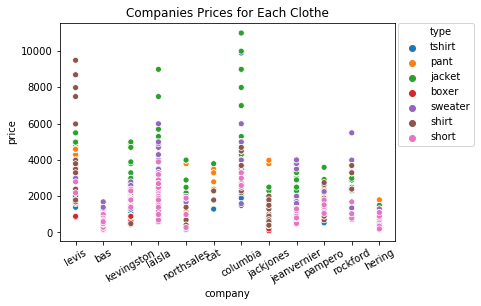

In [28]:
sns.scatterplot(x = "company", y = "price", data = df2, hue = "type")
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.title("Companies Prices for Each Clothe")
plt.show()

For the date of gathering we can see that Levis, Columbia and La Isla have ones of the expensives clothes, trends like BAS and Hering have the cheapest prices.  Jackets and shirts are the high valued products, whereas shorts and underwares tend to be the lowest ones.

The second graphic corresponds to a heatmap, here it is shown the number of items presented on the web for each clothes and for each company. The colors help us to visualize the data, as the more obscure the cell the higher of the count value. 

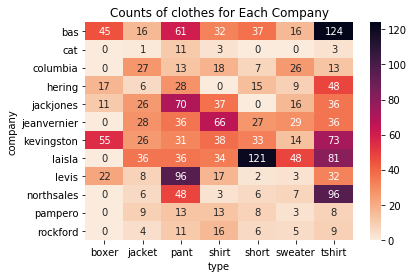

In [29]:
cross = pd.crosstab(index = df2['company'],
                    columns = df2['type'])
sns.heatmap(cross, cmap='rocket_r', annot=True, fmt='g')
plt.title("Counts of clothes for Each Company")
plt.show()

With the heatmap we try to complement the information of the first graphic. Now we are not seeing the price of the products, instead of that we can inspect the offer level that each company and each type of clothes shows on the web. 

Companies like BAS, La Isla, Kecingston and Jean Vernier offer the highest number of products, whereas Rockford, Pampero and CAT shows really few numbers of clothes in their Mercado Libre sites. T-shirts and pants are clearly the highest offered products, and underwares tend to be poerly offered.

#### 4.2 Description by product: Levis example

We can focus the inspection over every product, but for simplicity we are going to take over one of them, the Levis company. To begin we produce a boxplot for the prices of every Levis clothes. Boxplots summarize useful statistical information, in a single graphic and for each category of interest we can see the median, 25% and 75% of the variable range distribution and also outliers if there are any.

From the graphic we can conclude that for Levis: shirts and jackets are the most expensive type of clothes whereas underwears and t-shirts are the cheapest; shirts had an extremely wide range of prices distribution and a mean significantly away from it most expensive kind of shirts, in the other hand products like shorts and sweaters had price distributions much more compact; underwears had almost no variance.

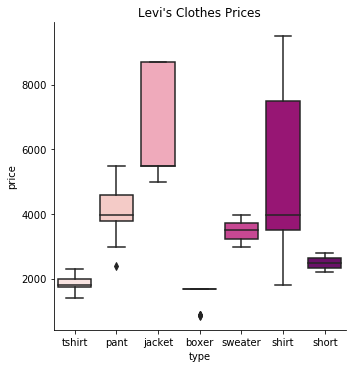

In [30]:
sns.catplot(x="type", y="price", 
            data=df2[df2["company"]=="levis"],
            kind="box",
            palette = "RdPu")
plt.title("Levi's Clothes Prices")
plt.show()

For more specific information, we can complement the outputs of the boxplot with a crosstab for each clothes as indexes and the min, mean and max values as columns. 

In [31]:
df2[df2["company"]=="levis"].groupby('type')['price']\
        .agg([np.min, np.mean, np.max]).reset_index()

,type,amin,mean,amax
0,boxer,850,1506.363636,1690
1,jacket,4980,6626.250000,8690
2,pant,2390,4069.583333,5490
3,shirt,1790,5221.764706,9490
4,short,2190,2490.000000,2790
5,sweater,2990,3486.666667,3980
6,tshirt,1390,1800.312500,2290


Then we can also filter the Levis data for price counts of each clothes. A simple barplot would show that every article tends to have a unique price.

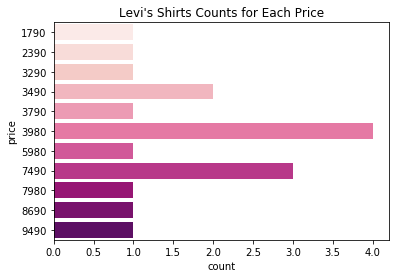

In [32]:
sns.countplot(data = df2[(df2.company == "levis") & (df2.type == "shirt")],
              y = "price",
              palette = "RdPu")
plt.title("Levi's Shirts Counts for Each Price")
plt.show()

#### 4.3 Description by clothes: example pants

Following the same steps as in the filter by company, we can start our clothes inspection with a boxplot. It could be seen that Levis, Rockford and Jack & Jones have the wider range of pants prices, whereas BAS; Columbia Jean Vernier and Hering are the ones with shortest ranges. Levis itself has the most expensive range of pants, nevertheless companies with cheaper median prices like Northsales, Columbia, Jack & Jones and Rockford has some outliers or punctually high prices articles that equals the majority of Levis prices.

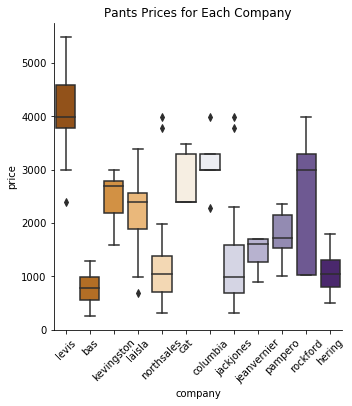

In [33]:
sns.catplot(x="company", y="price", 
            data=df2[df2["type"]=="pant"],
            kind="box",
            palette = "PuOr")
plt.xticks(rotation=45)
plt.title("Pants Prices for Each Company")
plt.show()

As in the company filter, we can complement the clothes segment with a crosstab, filtered in this case by pants, for all companies min, mean and max prices.

In [34]:
df2[df2["type"]=="pant"].groupby('company')['price']\
        .agg([np.min, np.mean, np.max]).reset_index()

,company,amin,mean,amax
0,bas,250,777.688525,1290
1,cat,2390,2771.818182,3490
2,columbia,2290,3128.461538,3990
3,hering,499,1016.857143,1799
4,jackjones,320,1177.457143,3980
5,jeanvernier,899,1482.333333,1699
6,kevingston,1590,2512.580645,2990
7,laisla,690,2273.333333,3390
8,levis,2390,4069.583333,5490
9,northsales,320,1211.520833,3980


For last but not for least we replicate the barplot of the last section. In the following example it could be seen the Hering count of pants for each price in the web market. Is clear that pants prices above 700 and below 1300 are the most frequent ones for this trend.

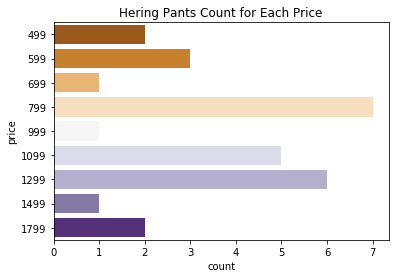

In [35]:
sns.countplot(data = df2[(df2.type == "pant") & (df2.company == "hering")],
              y = "price",
            palette = "PuOr")
plt.title("Hering Pants Count for Each Price")
plt.show()

That would be all for this project. As a recap, we saw a way to scrape data from the web in html format using beautiful soup, requests and regular expressions; we took advantage of functions to develop an scalable way of working and finally use seaborn to create useful graphics for descriptive analysis. With all this work we had created a tool for decision taking in a specifical market. 

If you want to look for further analysis, it is important to know that there are so many more ways of scraping data, some even much more efficient and scalable than this one. Scrapy is for example an advanced Python library that can not be taken out of consideration. Also there are other ways of present the data, libraries like Dash have the power of create interactive dashboards that you can share by an internet link.